# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Daten laden und vorverarbeiten

In [2]:
train=pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train.csv') 
test=pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test.csv')   

In [3]:
train["file_path"] = train["Id"].apply(lambda x: "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train/" + x + ".jpg")
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test["file_path"] = test["Id"].apply(lambda x: "/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test/" + x + ".jpg")
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

In [4]:
#train

In [5]:
image_size = 128
def preprocess(image_url):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return image
x_train=[]
for i in train['file_path']:
    x1=preprocess(i)
    x_train.append(x1)
    
    
X=np.array(x_train)
y=train['Pawpularity']  

2023-02-28 11:27:37.121970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 11:27:37.122121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [6]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)  

# ResNet50 

In [7]:
def create_model(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)

    # connects base model with new "head"
    BottleneckLayer = {
        'flatten': keras.layers.Flatten(),
        'avg': keras.layers.GlobalAveragePooling2D(),
        'max': keras.layers.GlobalMaxPool2D()
    }[top]

    base = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    x = BottleneckLayer(base.output)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(inputs=base.inputs, outputs=x)
    return model


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',patience=10, verbose=1,mode='min',restore_best_weights=True
    )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_rmse",
    factor=0.2,
    patience=3, 
    min_lr=1e-7,
    verbose=1,
    mode='min'
    )
callbacks = [early_stop,reduce_lr]


input_shape=(128,128,3)
model=create_model(input_shape)

In [8]:
#model.summary()

# Training mit Verlustfunktion "mse"

In [9]:
model.compile(loss='mse', optimizer='Adam', metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae"])

In [10]:
#history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_test,y_test),callbacks=callbacks)

#you can use this to provide your model with different variations of the same images. 
# It doesn't actually make and save a bunch of new images, just defines how new images can be created. 
# These transformations will randomly be applied to the training images as they get used in training.
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 20
)

Epoch 1/20


2023-02-28 11:31:04.013705: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-28 11:31:06.788250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - ETA: 0s - loss: 534.7656 - rmse: 23.1250 - mae: 17.0820

2023-02-28 11:31:56.810642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - 58s 202ms/step - loss: 534.7656 - rmse: 23.1250 - mae: 17.0820 - val_loss: 468.2699 - val_rmse: 21.6395 - val_mae: 15.1141
Epoch 2/20
247/247 [==============================] - 46s 185ms/step - loss: 445.4940 - rmse: 21.1067 - mae: 15.8641 - val_loss: 443.6807 - val_rmse: 21.0637 - val_mae: 15.4717
Epoch 3/20
247/247 [==============================] - 44s 176ms/step - loss: 439.7207 - rmse: 20.9695 - mae: 15.7313 - val_loss: 488.9815 - val_rmse: 22.1129 - val_mae: 15.8689
Epoch 4/20
247/247 [==============================] - 44s 178ms/step - loss: 434.9478 - rmse: 20.8554 - mae: 15.6229 - val_loss: 492.6223 - val_rmse: 22.1951 - val_mae: 15.6799
Epoch 5/20
247/247 [==============================] - 44s 177ms/step - loss: 430.3675 - rmse: 20.7453 - mae: 15.5520 - val_loss: 449.1687 - val_rmse: 21.1936 - val_mae: 16.8069
Epoch 6/20
247/247 [==============================] - 44s 177ms/step - loss: 428.5675 - rmse: 20.7019 - mae: 15.5562 - val_los

# Model evaluieren

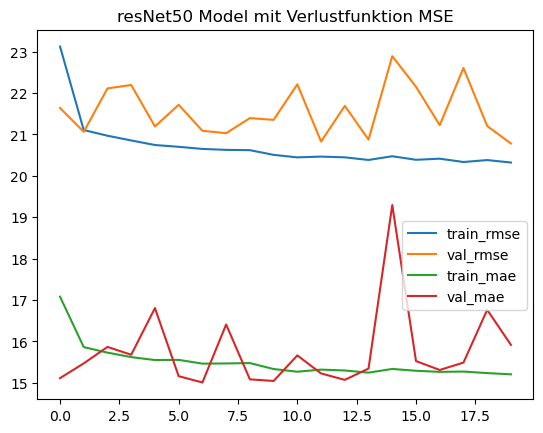

In [11]:
plt.figure()
plt.title("resNet50 Model mit Verlustfunktion MSE")

plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('4_resNet50_Model_mit_Verlustfunktion_MSE.png')
plt.show()

# Training mit Verlustfunktion "mae"

In [12]:
#compile the model
model.compile(
    loss = 'mae', 
    optimizer ='Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae"])

In [ ]:
#you can use this to provide your model with different variations of the same images. 
# It doesn't actually make and save a bunch of new images, just defines how new images can be created. 
# These transformations will randomly be applied to the training images as they get used in training.
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

history2 = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 20
)

Epoch 1/20


2023-02-28 11:45:59.494349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - ETA: 0s - loss: 14.9250 - rmse: 21.0862 - mae: 14.9250

2023-02-28 11:46:49.145182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - 59s 205ms/step - loss: 14.9250 - rmse: 21.0862 - mae: 14.9250 - val_loss: 15.1015 - val_rmse: 21.8157 - val_mae: 15.1015
Epoch 2/20
247/247 [==============================] - 44s 178ms/step - loss: 14.9382 - rmse: 21.1077 - mae: 14.9382 - val_loss: 16.9410 - val_rmse: 24.4417 - val_mae: 16.9410
Epoch 3/20
247/247 [==============================] - 44s 176ms/step - loss: 15.0884 - rmse: 21.2872 - mae: 15.0884 - val_loss: 15.1333 - val_rmse: 21.8551 - val_mae: 15.1333
Epoch 4/20
247/247 [==============================] - 43s 175ms/step - loss: 14.8619 - rmse: 21.1281 - mae: 14.8619 - val_loss: 14.9357 - val_rmse: 21.3006 - val_mae: 14.9357
Epoch 5/20
247/247 [==============================] - 44s 178ms/step - loss: 14.8528 - rmse: 21.0307 - mae: 14.8528 - val_loss: 15.0812 - val_rmse: 21.0479 - val_mae: 15.0812
Epoch 6/20
247/247 [==============================] - 44s 176ms/step - loss: 14.8608 - rmse: 21.0980 - mae: 14.8608 - val_loss: 15.6775 

# Model erneut evaluieren

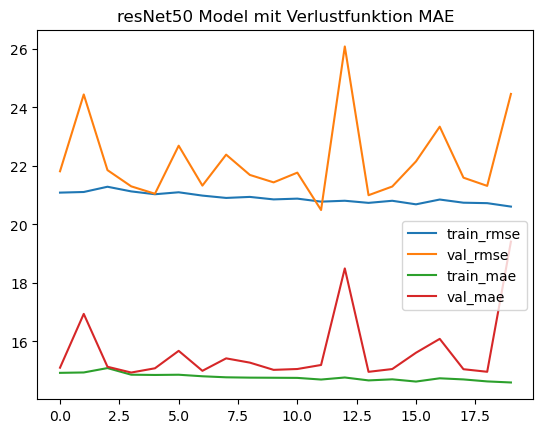

In [14]:
plt.figure()
plt.title("resNet50 Model mit Verlustfunktion MAE")

plt.plot(history2.history["rmse"], label="train_rmse")
plt.plot(history2.history["val_rmse"], label="val_rmse")
plt.plot(history2.history["mae"], label="train_mae")
plt.plot(history2.history["val_mae"], label="val_mae")

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('5_resNet50_Model_mit_Verlustfunktion_MAE.png')
plt.show()

# Vergleich

/var/folders/7l/64k945l9567573m_x6qrs0_80000gn/T/ipykernel_17416/2496534948.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


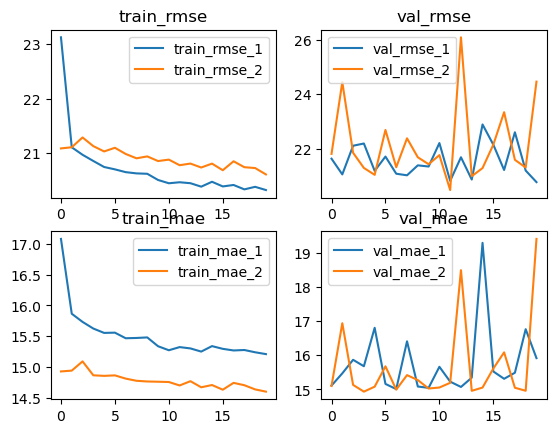

In [15]:
plt.figure()
plt.title("Trainingperformance")

plt.subplot(221)
plt.title('train_rmse')
plt.plot(history.history["rmse"], label="train_rmse_1")
plt.plot(history2.history["rmse"], label="train_rmse_2")
plt.legend()

plt.subplot(222)
plt.title('val_rmse')
plt.plot(history.history["val_rmse"], label="val_rmse_1")
plt.plot(history2.history["val_rmse"], label="val_rmse_2")
plt.legend()

plt.subplot(223)
plt.title('train_mae')
plt.plot(history.history["mae"], label="train_mae_1")
plt.plot(history2.history["mae"], label="train_mae_2")
plt.legend()

plt.subplot(224)
plt.title('val_mae')
plt.plot(history.history["val_mae"], label="val_mae_1")
plt.plot(history2.history["val_mae"], label="val_mae_2")
plt.legend()

plt.savefig('6_resNet50_Model_Gesamt.png')
plt.show()